In [1]:
# !pip install PyWavelets
!pwd
# ! unzip data.zip
! git clone https://github.com/chian-chen/BELab.git

/content
Cloning into 'BELab'...
remote: Enumerating objects: 6301, done.
remote: Counting objects: 100% (6301/6301), done.
remote: Compressing objects: 100% (6149/6149), done.
remote: Total 6301 (delta 211), reused 6226 (delta 149), pack-reused 0
Receiving objects: 100% (6301/6301), 7.27 MiB | 4.28 MiB/s, done.
Resolving deltas: 100% (211/211), done.


In [2]:
import numpy as np
import os
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
# from scipy import signal
import random
import pywt
import matplotlib.pyplot as plt


In [3]:
toprint_gau = []
toprint_cat = []

left = []
right = []
z = []
n = []
def normalize(signal):
    # for s in signal:
    #     # s = (s-np.mean(s))/np.sqrt(np.var(s))
    #     s = (s-np.mean(s))
    # signal = signal - np.mean(signal)
    # if np.sum(signal) > 0:
    #     signal /= np.sum(signal) 
    # return signal
    return signal - np.mean(signal)
def find_max_segment_power(signal, length):
    max_i = 0
    max_pow = -1
    for i in range(signal.shape[0] - length):
        if np.square(signal[i:i+length]).sum() > max_pow:
            max_i = i
            max_pow = np.square(signal[i:i+length]).sum()
            # print(max_i, max_pow)
        # print(i, i+length, np.square(signal[i:i+length]).sum(),  max_pow)
    return signal[max_i:max_i+length]

def process_signal(signal):
    # data = np.array([
    #     signal['x'], 
    #     signal['rx'],  
    #     signal['y'], 
    #     signal['ry'], 
    #     signal['z'], 
    #     signal['rz'],
    # ])
    data = np.array([
        signal['x'], 
        signal['y'], 
        signal['z'], 
    ])
    length = 80
    process_data = np.zeros((data.shape[0], length))

    for i in range(len(data)):
        data[i] = normalize(data[i])
        process_data[i] = find_max_segment_power(data[i], length)


        # print(s.shape)
    # print(process_data.shape)

    return process_data

def add_noise(data, noises = None):
    """
    signal is (3, 80) np array
    noises is list of (3, 80) noise
    signal = signal + l * noise 
    """
    if noises == None:
        return data
    p = 0.3
    up_bound = 0.5
    idx = np.random.randint(0, len(noises))
    # noise_data = np.zeros(data.shape)
    l = np.random.rand() * up_bound
    # if np.isnan(np.sum(noises[idx], axis = 1)/np.sum(data, axis = 1)).any():
    #     print(data)

    data = data + l * noises[idx]

    return data  

def gen_noise_data(noises, X, y):
    '''
    Generate noise data append to dataset
    [noise 50 point, data 30 point]
    '''
    len_x = len(X)
    len_n = len(noises)
    num_add = 500
    l_n = 50
    l_d = 30
    for i in range(num_add):
        idx = random.randint(0, len_x-1)
        idx_n = random.randint(0, len_n-1)
        # sig = np.array(X[idx][0])
        # print(sig.shape)
        sig = X[idx][0]
        noise = noises[idx_n].tolist()
        start_n = random.randint(0, len(noise[0])-1-l_n)
        new_sig = []
        new_sig.append(noise[0][start_n:start_n+50])
        new_sig.append(noise[1][start_n:start_n+50])
        new_sig.append(noise[2][start_n:start_n+50])
        # print(type(new_sig))
        new_sig[0].extend(sig[0][:l_d])
        new_sig[1].extend(sig[1][:l_d])
        new_sig[2].extend(sig[2][:l_d])

        # print(np.array(new_sig).shape)
        
        X.append(np.expand_dims(new_sig, 0).tolist())
        y.append(8) #noise
        toprint_cat.append(new_sig)
    

    for i in range(num_add):
        sig = []
        mean = 0
        sigma = 0.01
        np.random.seed(i)

        for dim in range(3):
            sig_one = []
            # for j in range(80):
            #     sig_one.append(random.gauss(mean, sigma))
            sig_one = np.random.normal(mean, sigma,(80,)).tolist()
            sig.append(sig_one)
         
        X.append(np.expand_dims(sig, 0).tolist())
        y.append(8) #noise           
        toprint_gau.append(sig)
    
    return X, y


def process_signal_dwt(signal):
    data = np.array([
        signal['x'], 
        signal['y'], signal['z']
    ])

    length = 80
    process_data = np.zeros((data.shape[0], length))
    process_data_dwt = np.zeros((data.shape[0], length))

    for i in range(len(data)):

        data[i] = normalize(data[i])
        process_data[i] = find_max_segment_power(data[i], length)
        cA, cD = pywt.dwt(process_data[i], 'db1')
        dwt_cat = np.concatenate((cA, cD), axis=0)
        # print(cA.shape)
        process_data[i] = dwt_cat


    return process_data
    #return normalize(data)

def preprocess_data(file_path):
    X = []
    y = []
    num_of_bad_data = 0
    label2digit = {"GestureDown":0, "GestureLeft":1, "GestureN":2,
                   "GestureO": 3, "GestureRight":4, "GestureUp":5, 
                   "GestureV": 6, "GestureZ": 7, "Noise":8
                   }
    
    # Get Noise first
    noises = []
    for file in os.listdir(f"{file_path}/Noise"):
        if os.path.isfile(f"{file_path}/Noise/{file}"):
            if  file.split('.')[1] == 'npz':
                signal = np.load(f"{file_path}/Noise/{file}")
                signal = process_signal(signal)
                noises.append(signal)

    for folder in os.listdir(file_path):
        if os.path.isdir(f"{file_path}/{folder}"):
            for file in os.listdir(f"{file_path}/{folder}"):
                if os.path.isfile(f"{file_path}/{folder}/{file}"):
                    if file.split('.')[1] == 'npz' and file.split('.')[0].split('_')[0]!='hung':
                        signal = np.load(f"{file_path}/{folder}/{file}")
                        is_good_data = True
                        # for rx_data in signal['rx']:
                        #     if rx_data > 1000 or rx_data < -1000:
                        #         print(f"{file_path}/{folder}/{file}")
                        #         num_of_bad_data += 1
                        #         is_good_data = False
                        #         break
                        if is_good_data:
                            # signal = process_signal_dwt(signal)
                            # print(signal.shape)
                            # print(type(signal))
                            signal = process_signal(signal)
                            signal = add_noise(signal, noises)

                            if folder == 'GestureZ':
                                z.append(signal)
                            if folder == 'GestureN':
                                n.append(signal)

                            if not np.isnan(signal).any() :
                                X.append(np.expand_dims(signal, 0).tolist())
                                y.append(label2digit[folder])
                            else:
                                num_of_bad_data += 1
                                print(f"{file_path}/{folder}/{file}")
    print(f'Total {num_of_bad_data} bad data!')
    print(len(X))
    X, y = gen_noise_data(noises, X, y)
    print(len(X))

    # print(X)
    # return X, y
    return torch.tensor(X), torch.tensor(y)
X, y = preprocess_data('/content/BELab/data')

Total 0 bad data!
5376
6376


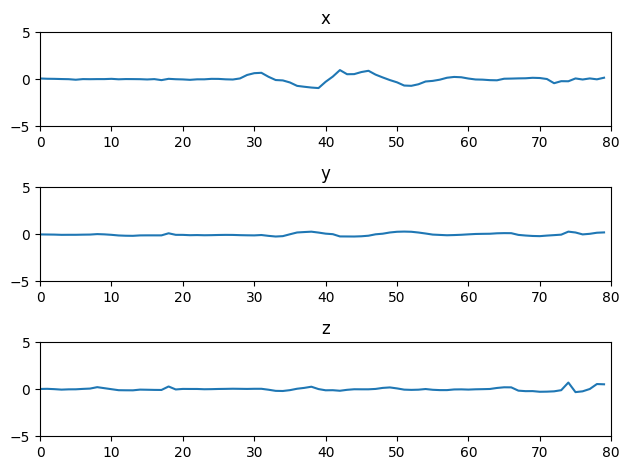

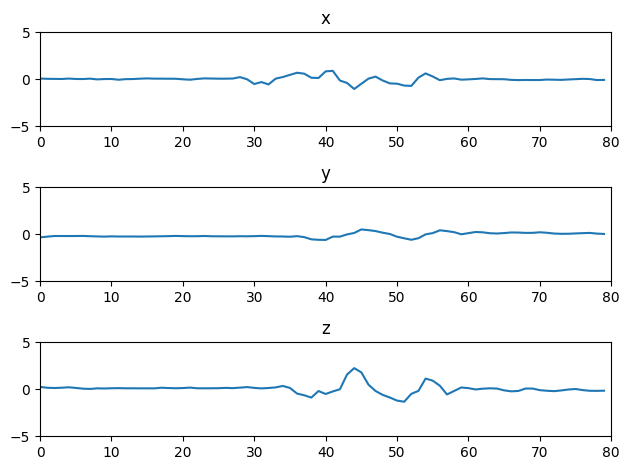

In [4]:
def plot_signal(signal):
    fig, ax = plt.subplots(3,1)
    ax[0].plot(signal[0])
    ax[0].set_title('x')
    ax[0].set_ylim([-5,5])
    ax[0].set_xlim([0,80])
    ax[1].plot(signal[1])
    ax[1].set_title('y')
    ax[1].set_ylim([-5,5])
    ax[1].set_xlim([0,80])
    ax[2].plot(signal[2])
    ax[2].set_title('z')
    ax[2].set_ylim([-5,5])
    ax[2].set_xlim([0,80])
    plt.grid(False)
    plt.tight_layout()
    plt.show()
# plot_signal(toprint_cat[0])
# plot_signal(toprint_cat[1])
# plot_signal(toprint_gau[0])
# plot_signal(toprint_gau[4])
plot_signal(z[0])
plot_signal(n[0])


In [5]:
X[0].shape

torch.Size([1, 3, 80])

In [6]:
from torch.utils.data import Dataset
class MyDataset(Dataset):
    def __init__(self, signals, labels):
        self.data = signals
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [7]:
batch_size = 10

my_data = MyDataset(X, y)

# Define the sizes of the training and validation sets
train_size = int(0.9 * len(my_data))
val_size = len(my_data) - train_size

# Split the dataset into training and validation sets
train_data, val_data = random_split(my_data, [train_size, val_size])

# Create data loaders for the training and validation sets
train_loader = DataLoader(train_data, batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size, shuffle=False)

In [8]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")
# Define model
class CNN_3axis(nn.Module):
    def __init__(self, num_class, hid_channel=196):
        super().__init__()
        self.num_class = num_class
        self.hid_channel = hid_channel
        self.cnn = nn.Conv2d(1, self.hid_channel, (1, 16))
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        # self.maxpool = nn.MaxPool2d((1, 4), stride=(1, 4))
        # self.maxpool = nn.MaxPool2d((1, 4))
        # self.fc = nn.Linear(self.hid_channel*3*18, 512)
        # self.dropout = nn.Dropout(0.5)        
        # self.fc = nn.Linear(self.hid_channel*3*18, 512)
        # self.dropout = nn.Dropout(0.5)
        # self.proj_class = nn.Linear(512, self.num_class)
        # self.cnn2 = nn.Conv2d(self.hid_channel, 2* self.hid_channel, (3, 3))
        self.proj = nn.Sequential(
            nn.Linear(self.hid_channel*3*65, 1024), 
            nn.ReLU(),
            nn.Dropout(0.5),
            # nn.Linear(2048, 1024),
            # nn.ReLU(),
            
            # nn.Linear(1024, 256),
            # nn.ReLU(),
            # nn.Dropout(0.5),
            nn.Linear(1024, self.num_class)
        )

    def forward(self, x):
        x = self.cnn(x)
        x = self.relu(x)
        # x = self.cnn2(x)
        # x = self.relu(x)

        x = x.view(x.size()[0], -1)
        x = self.proj(x)
        return x

class CNN(nn.Module):
    def __init__(self, num_class, out_channel=196):
        super().__init__()
        self.num_class = num_class
        self.out_channel = out_channel
        self.cnn = nn.Conv2d(1, self.out_channel, (1, 16))
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d((2, 4), stride=(2, 4))
        self.fc = nn.Linear(self.out_channel*3*16, 256)
        self.dropout = nn.Dropout(0.5)
        self.proj_class = nn.Linear(256, self.num_class)


    def forward(self, x):
        x = self.cnn(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = x.view(x.size()[0], -1)
        x = self.fc(x)
        x = self.dropout(x)
        x = self.proj_class(x)
        return x

class CNN_dwt(nn.Module):
    def __init__(self, num_class, out_channel=196):
        super().__init__()
        self.num_class = num_class
        self.out_channel = out_channel
        self.cnn = nn.Conv2d(1, self.out_channel, (1, 16))
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d((2, 4), stride=(2, 4))
        self.fc = nn.Linear(self.out_channel*3*6, 256)
        self.dropout = nn.Dropout(0.6)
        self.proj_class = nn.Linear(256, self.num_class)


    def forward(self, x):
        x = self.cnn(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = x.view(x.size()[0], -1)
        x = self.fc(x)
        x = self.dropout(x)
        x = self.proj_class(x)
        return x

# model = CNN(9, 12).to(device)
model = CNN_3axis(9, 96).to(device)
# print(model)

# model = CNN_dwt(9, 10).to(device)
# print(model)
# total_params = sum(p.numel() for p in model.parameters())
# print(total_params)

Using cuda device
CNN_3axis(
  (cnn): Conv2d(1, 96, kernel_size=(1, 16), stride=(1, 1))
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (proj): Sequential(
    (0): Linear(in_features=18720, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=1024, out_features=9, bias=True)
  )
)
19181161


In [9]:
from torchsummary import summary
summary(model, (1,3,80))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 96, 3, 65]           1,632
              ReLU-2            [-1, 96, 3, 65]               0
            Linear-3                 [-1, 1024]      19,170,304
              ReLU-4                 [-1, 1024]               0
           Dropout-5                 [-1, 1024]               0
            Linear-6                    [-1, 9]           9,225
Total params: 19,181,161
Trainable params: 19,181,161
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.31
Params size (MB): 73.17
Estimated Total Size (MB): 73.48
----------------------------------------------------------------


In [10]:
input = torch.randn(1, 1, 3, 40).to(device)
input2 = torch.randn(1, 1, 3, 80).to(device)
output = model(input2)
print(output.shape)

torch.Size([1, 9])


In [11]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    print(size)
    model.train()
    i = 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        if i == 0:
            print(X.shape)
            print(X.dtype)
            i += 1
        # print(X)
        # Compute prediction error
        pred = model(X)
        # print(pred)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 10 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
def valid(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            X = X.to(torch.float32)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    acc = correct / size
    print(f"Test Error: \n Accuracy: {(100*acc):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return acc

In [12]:
epochs = 5
best_acc = 0
for t in range(epochs):
    print(f"--------------Epoch {t+1}-----------------")
    train(train_loader, model, loss_fn, optimizer)
    cur_acc = valid(val_loader, model, loss_fn)
    if cur_acc > best_acc:
        best_acc = cur_acc
        print(f"Save better model on epoch {t+1}")
        torch.save(model.state_dict(), "best_model.pth")
print("Done!")
print(f'Best acc {best_acc}')

--------------Epoch 1-----------------
5738
torch.Size([10, 1, 3, 80])
torch.float32
loss: 2.204926  [   10/ 5738]
loss: 3.723535  [  110/ 5738]
loss: 2.287306  [  210/ 5738]
loss: 0.550049  [  310/ 5738]
loss: 1.827252  [  410/ 5738]
loss: 1.184309  [  510/ 5738]
loss: 0.969542  [  610/ 5738]
loss: 0.577342  [  710/ 5738]
loss: 0.823613  [  810/ 5738]
loss: 0.903413  [  910/ 5738]
loss: 0.826285  [ 1010/ 5738]
loss: 0.669514  [ 1110/ 5738]
loss: 1.340606  [ 1210/ 5738]
loss: 0.451912  [ 1310/ 5738]
loss: 0.746029  [ 1410/ 5738]
loss: 0.673118  [ 1510/ 5738]
loss: 1.015551  [ 1610/ 5738]
loss: 0.152774  [ 1710/ 5738]
loss: 0.924320  [ 1810/ 5738]
loss: 0.215558  [ 1910/ 5738]
loss: 0.388275  [ 2010/ 5738]
loss: 1.135420  [ 2110/ 5738]
loss: 0.400789  [ 2210/ 5738]
loss: 0.941430  [ 2310/ 5738]
loss: 0.231023  [ 2410/ 5738]
loss: 0.540812  [ 2510/ 5738]
loss: 0.562417  [ 2610/ 5738]
loss: 0.598573  [ 2710/ 5738]
loss: 0.923630  [ 2810/ 5738]
loss: 0.425337  [ 2910/ 5738]
loss: 0.972362 

[[ 41   0   0   0   0   1   0   0   2]
 [  0  45   0   0   6   0   0   1   1]
 [  0   0  34   4   1   0   0   2   1]
 [  0   0   0  50   0   0   0   0   0]
 [  0   0   0   0  51   0   0   2   0]
 [  2   0   0   0   0  42   0   0   0]
 [  3   0   0   1   0   0  36   0   7]
 [  0   1   1   0   0   0   0  41   0]
 [  0   1   3   1   0   0   0   0 257]]
[[ 41   0   0   0   0   1   0   0   2]
 [  0  45   0   0   6   0   0   1   1]
 [  0   0  34   4   1   0   0   2   1]
 [  0   0   0  50   0   0   0   0   0]
 [  0   0   0   0  51   0   0   2   0]
 [  2   0   0   0   0  42   0   0   0]
 [  3   0   0   1   0   0  36   0   7]
 [  0   1   1   0   0   0   0  41   0]
 [  0   1   3   1   0   0   0   0 257]]


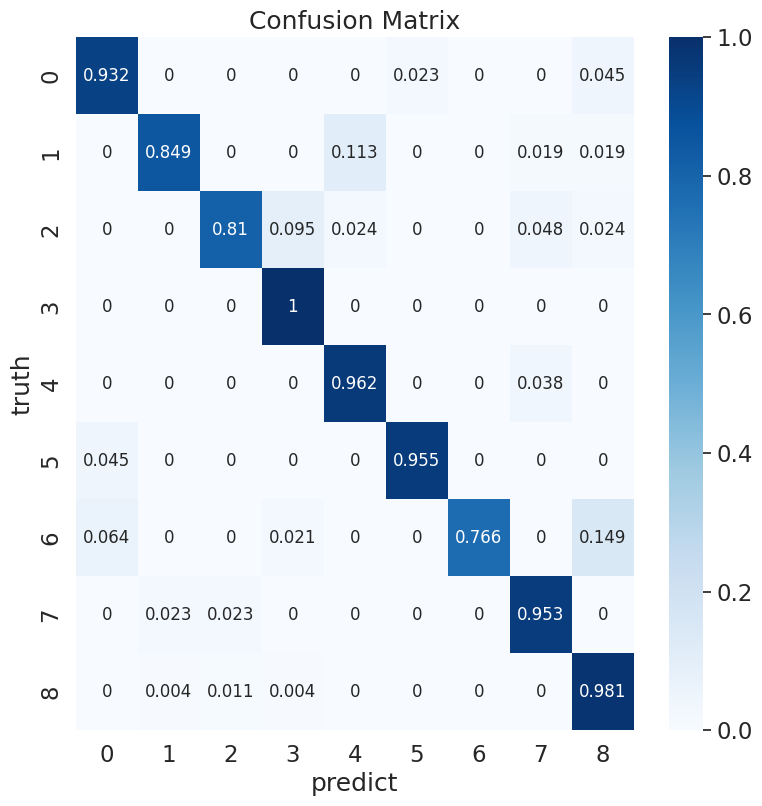

In [13]:
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure


def valid_cf(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    valid_labels = []
    valid_prediction = []
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            X = X.to(torch.float32)
            pred = model(X)
            valid_labels.extend(y.cpu())
            valid_prediction.extend(pred.argmax(1).cpu())
    return valid_labels, valid_prediction


# define function
def plot_confusion_matrix(cm):
    ncm = []
    title = 'Confusion Matrix'
    print((cm))
    new_cm = []
    for i in range(len(cm)):
        # print(cm[i])
        new_cm.append(np.round(cm[i]/np.sum(cm[i]), 3))
        # cm[i] = cm[i] / np.sum(cm[i])
    print((cm))
    # df_cm = pd.DataFrame(cm, range(9), range(9))
    df_cm = pd.DataFrame(new_cm, range(9), range(9))
    # print(df_cm)
    
    plt.figure(figsize=(9, 9))
    sns.set(font_scale=1.5) 
    sns.heatmap(df_cm, annot=True, linewidths=0, annot_kws={"size": 12}, cmap="Blues", fmt='g')
    plt.xlabel('predict') # 橫軸是 prediction
    plt.ylabel('truth')   # 縱軸是 truth
    plt.title(title)
    plt.savefig('cf.png')
    plt.show()
valid_labels, valid_prediction = valid_cf(val_loader, model, loss_fn)
cf_m = confusion_matrix(valid_labels, valid_prediction)
plot_confusion_matrix(cf_m)


    # label2digit = {"GestureDown":0, "GestureLeft":1, "GestureN":2,
    #                "GestureO": 3, "GestureRight":4, "GestureUp":5, 
    #                "GestureV": 6, "GestureZ": 7, "Noise":8
    #                }


In [14]:
from sklearn import svm
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA

# Create a PCA instance
pca = PCA(n_components=20)




clf = svm.SVC()
# Fit the classifier to the training data
train_x = []
for train in train_data[:][0]:
    train = train.view(train.size()[0], -1)
    # print(train.shape)
    train = train.squeeze(0)
    # print(train.shape)
    train_x.append(list(train))
# Fit PCA on the dataset
train_x_transformed = pca.fit_transform(train_x)

valid_x = []
for valid in val_data[:][0]:
    valid = valid.view(valid.size()[0], -1)
    valid = valid.squeeze(0)
    valid_x.append(list(valid))
clf.fit(train_x_transformed, train_data[:][1])
valid_x_transformed = pca.fit_transform(valid_x)

print('End train')
# Predict the labels for the test data
y_pred = clf.predict(valid_x_transformed)
print('End predict')

# Calculate the accuracy of the classifier
accuracy = accuracy_score(val_data[:][1], y_pred)
print("Accuracy:", accuracy)


# without PCA
# Accuracy: 0.842809364548495


End train
End predict
Accuracy: 0.493730407523511
